# Kernel-Based Conditional Density Estimation Notebook

 In this notebook we generate Brownian motion trajectories, "train" a conditional density estimator using a kernel‐based method, 
 and then evaluate the estimator by drawing samples at a specific stage.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

import sys
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


measure_sampling_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling')
CD_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density')

if measure_sampling_path not in sys.path:
    sys.path.append(measure_sampling_path)

if CD_path not in sys.path:
    sys.path.append(CD_path)

from CD_nonparam import *

from Gen_Path_and_AdaptedTrees import *

In [2]:
# Generate Brownian motion paths
n_data =  30
time_steps = 4  # For example, t=0, t=1, t=2, t=3
paths = generate_brownian_motion(num_paths=n_data, time_steps=time_steps, scale=1)

Samples at stage 3:
[-0.42751792  1.54289677  2.18038906  2.19721573  0.15248084  0.7102862
 -1.20354772  1.37339027 -0.72250687  0.77038302  1.12783738  1.32095143
  1.41476244  0.74274461  0.78978722  0.40543798 -3.95258416 -0.4560606
  0.10024011  1.59002936]


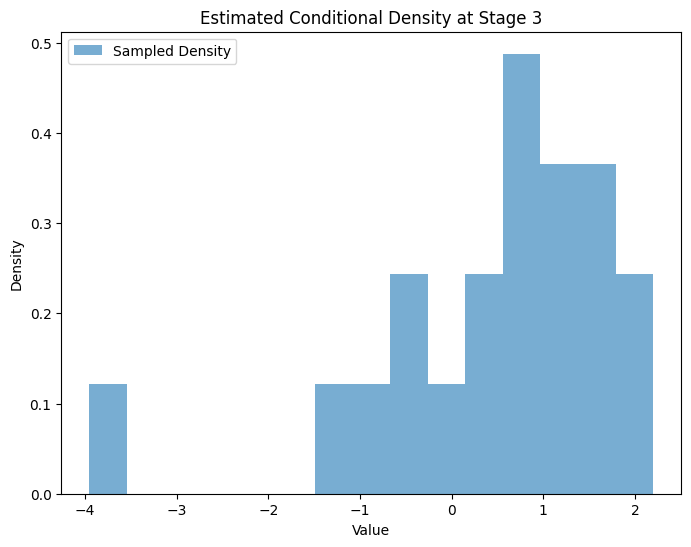

In [3]:
# %%
# Train the kernel-based conditional density estimator.
# Here we use the default logistic kernel; you could also pass norm for a Gaussian kernel.
from scipy.stats import logistic 
estimator = train_conditional_density_kernel(paths, kernelDistribution=logistic, Markovian=True)

# %%
# Evaluate the estimator at a given stage.
# For example, suppose we want to sample the conditional density at stage 3 (i.e. the third time step).
stage = 3         # Using 1-indexing (stage 3 corresponds to the third element of each trajectory)
n_samples = 20    # Number of samples to draw at stage 3
samples = evaluate_conditional_density_kernel(estimator, stage, n_samples=n_samples)
print("Samples at stage {}:".format(stage))
print(samples)

# %%
# Visualize the estimated density by plotting a histogram of the samples.
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=15, density=True, alpha=0.6, label='Sampled Density')
plt.title("Estimated Conditional Density at Stage {}".format(stage))
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

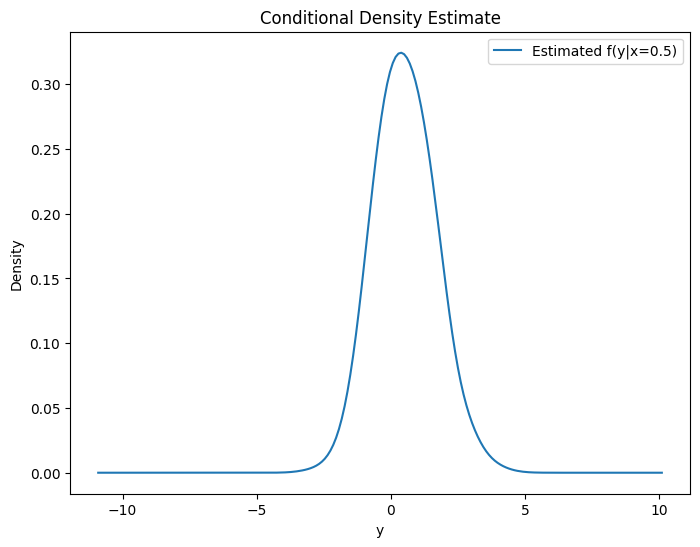

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

def estimate_conditional_density(data, x0, bandwidth_joint, bandwidth_marginal, y_grid):
    """
    Estimates the conditional density f(y|x0) via kernel density estimation.
    
    Args:
        data (np.ndarray): 2D array with shape (n_samples, 2) where the first column is x and the second is y.
        x0 (float): The fixed value of x at which the conditional density is evaluated.
        bandwidth_joint (float): Bandwidth used for estimating the joint density f(x,y).
        bandwidth_marginal (float): Bandwidth used for estimating the marginal density f(x).
        y_grid (np.ndarray): 1D array of y values at which to evaluate the conditional density.
        
    Returns:
        f_cond (np.ndarray): The estimated conditional density values evaluated at the given y_grid.
    """
    # Fit the joint density estimator on the (x,y) data
    kde_joint = KernelDensity(kernel='gaussian', bandwidth=bandwidth_joint)
    kde_joint.fit(data)
    
    # For each y in the grid, evaluate the joint density at (x0, y)
    X_eval = np.column_stack([np.full(len(y_grid), x0), y_grid])
    log_f_joint = kde_joint.score_samples(X_eval)
    f_joint = np.exp(log_f_joint)
    
    # Fit the marginal density estimator on the x-values only
    kde_x = KernelDensity(kernel='gaussian', bandwidth=bandwidth_marginal)
    kde_x.fit(data[:, 0].reshape(-1, 1))
    log_f_x = kde_x.score_samples([[x0]])
    f_x = np.exp(log_f_x)[0]
    
    # Compute the conditional density
    f_cond = f_joint / f_x
    return f_cond

# Example: generate synthetic Brownian motion data
def generate_brownian_motion(num_paths, time_steps, scale=1.0):
    dt = 1.0
    # Each path is a cumulative sum of Gaussian increments.
    paths = np.cumsum(np.random.normal(0, scale * np.sqrt(dt), size=(num_paths, time_steps)), axis=1)
    return paths

# Generate data
num_paths = 3000
time_steps = 4
paths = generate_brownian_motion(num_paths, time_steps, scale=1.0)

# For conditional density estimation, let’s say we want to condition on a value of x at time step 2
# and estimate the density for y at time step 3.
# (You can choose any two stages, here we follow a similar convention to your previous setup.)
X = paths[:, 2].reshape(-1, 1)
Y = paths[:, 3].reshape(-1, 1)
data = np.concatenate([X, Y], axis=1)

# Define a grid of y values covering the range of Y (plus a little margin)
y_min = np.min(Y) - 3
y_max = np.max(Y) + 3
y_grid = np.linspace(y_min, y_max, 200)

# Specify a conditioning value x0 (for example, x0 = 0.5)
x0 = 0.5

# Set bandwidth parameters (you may need to tune these)
bandwidth_joint = 0.5
bandwidth_marginal = 0.5

# Estimate the conditional density f(y|x0)
f_cond = estimate_conditional_density(data, x0, bandwidth_joint, bandwidth_marginal, y_grid)

# Plot the estimated conditional density
plt.figure(figsize=(8, 6))
plt.plot(y_grid, f_cond, label=f"Estimated f(y|x={x0})")
plt.title("Conditional Density Estimate")
plt.xlabel("y")
plt.ylabel("Density")
plt.legend()
plt.show()
